In [1]:
# Name: probabilistic_model_constructions.ipynb
# Authors: Stephan Meighen-Berger
# Constructs a probabilistic model which can be used instead of the cpu heavy simulation
# Still in BETA!!!

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
# Scenario Settings
# These are general settings pertaining to the simulation run
config['scenario']['population size'] = 1  # The starting population size
config['scenario']['duration'] = 600 * 1  # Total simulation time in seconds
config['scenario']['exclusion'] = True  # If an exclusion zone should be used (the detector)
config['scenario']['injection']['rate'] = 1e0  #  Injection rate in per second, a distribution is constructed from this value
pos_det_y = 0.5 * 15. - 0.15
config['scenario']['injection']['y range'] = [pos_det_y - 5., pos_det_y + 5.]  # The y-range of injection
config['scenario']['light prop'] = {  # Where the emitted light should be propagated to (typically the detector location)
            "switch": False,  # If light should be propagated
            "x_pos": 3.,  # The x-coordinates
            "y_pos": 0.5 * 15. - 0.15,  # The y-coordinates
        }
config['scenario']['detector'] = {  # detector specific properties, positions are defined as offsets from the light prop values
    "switch": False,  # If the detector should be modelled
    "type": "PMTSpec",  # Detector name, implemented types are given in the config
    "response": True,  # If a detector response should be used
    "acceptance": "Flat",  # Flat acceptance
    "mean detection prob": 0.5  # Used for the acceptance calculation
}
# ---------------------------------------------
# Organisms
# Organisms properties are defined here
config['organisms']['emission fraction'] = 0.1  # Amount of energy an organism uses per pulse
config['organisms']['alpha'] = 5e0  # Proportionality factor for the emission probability
config['organisms']["minimal shear stress"] = 0.05  # The minimal amount of shear stress needed to emit (generic units)
config["organisms"]["filter"] = 'depth'  # Method of filtering organisms (here depth)
config["organisms"]["depth filter"] = 1000.  # Organisms need to exist below this depth
# ---------------------------------------------
# Geometry
# These settings define the geometry of the system
# Typically a box (simulation volume) with a spherical exclusion zone (detector)
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    'offset': None,
}
# Reduce the observation size to reduce the computational load
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    "offset": np.array([0., 0.]),
}
# The detector volume
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 3.,
    "y_pos": 0.5 * 15. - 0.15,
}
# ---------------------------------------------
# Water
# Properties of the current model
config['water']['model']['name'] = 'custom'  # Use a custom (non analytic) model
config['water']['model']['off set'] = np.array([0., 0.])  # Offset of the custom model
config['water']['model']['directory'] = "../data/current/Parabola_5mm/run_10cm_npy/"  # The files used by the custom model
config['water']['model']['time step'] = 1.  # in Seconds

In [9]:
runs = 1000
alpha = 1e1
# Storage
x_all = []
y_all = []
x_flash = []
y_flash = []
for seed in tqdm(range(runs)):
    # Create new data
    config['scenario']['class'] = 'New'
    # Seed
    config['general']["random state seed"] = seed
    # Alpha
    config['organisms']['alpha'] = alpha
    # Creating a fourth_day object
    fd = Fourth_Day()
    # Launching solver
    fd.sim()
    # Analyzing data
    # Temporary storage
    x_loc = []
    y_loc = []
    x_loc_flash = []
    y_loc_flash = []
    # Fetching all positions and only the flashers
    for stat in fd.statistics:
        # All of them
        x_loc.append(stat["pos_x"].values)
        y_loc.append(stat["pos_y"].values)
        # Only the flashers
        # Making sure there is something to work with
        tmp = stat["pos_x"].values[stat["pulse start"].values]
        tmp2 = stat["pos_y"].values[stat["pulse start"].values]
        if len(tmp) > 0:
            x_loc_flash.append(tmp)
            y_loc_flash.append(tmp2)
        else:
            continue
    x_loc = np.array(x_loc).ravel()
    y_loc = np.array(y_loc).ravel()
    # Errors can happen if empty
    try:
        x_loc_flash = np.array(x_loc_flash).ravel()
        y_loc_flash = np.array(y_loc_flash).ravel()
    except:
        continue
    x_all.append(x_loc)
    y_all.append(y_loc)
    x_flash.append(x_loc_flash)
    y_flash.append(y_loc_flash)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [34:16:59<00:00, 123.42s/it]


In [10]:
pickle.dump([x_all, y_all, x_flash, y_flash], open("probability_model/offcenter_10cm_raw_v4.pkl", "wb" ) )

In [14]:
# For the binning
xedges = np.linspace(0., 30., 91)
yedges = np.linspace(0., 15., 46)

In [20]:
# Flattening and touching up
x_all = np.array([np.array([elem]).flatten() for elem in x_all])
y_all = np.array([np.array([elem]).flatten() for elem in y_all])
x_flash = np.array([np.array([elem]).flatten() for elem in x_flash])
y_flash = np.array([np.array([elem]).flatten() for elem in y_flash])
x_all = np.concatenate(x_all).ravel()
y_all = np.concatenate(y_all).ravel()
x_flash = np.concatenate(x_flash).ravel()
y_flash = np.concatenate(y_flash).ravel()

KeyboardInterrupt: 

In [16]:
# Binning
H_all, xedges, yedges = np.histogram2d(x_all, y_all, bins=(xedges, yedges))
H_flash, xedges, yedges = np.histogram2d(x_flash, y_flash, bins=(xedges, yedges))
pickle.dump([xedges, yedges, H_all, H_flash], open("probability_model/offcenter_10cm_v4.pkl", "wb" ) )

In [17]:
# Style
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [18]:
# Plotting standards
std_size = 20.
fontsize = 20.
lw=1.
h_length=1.

OSError: [Errno 22] Invalid argument: '../pics/Organism_Flashes.png'

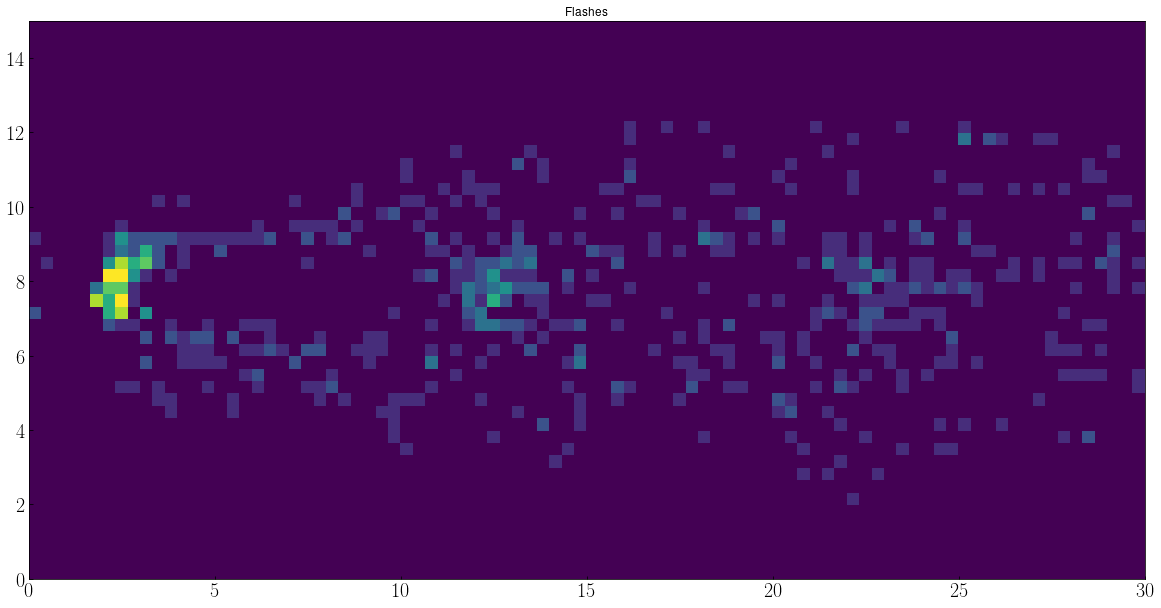

In [19]:
# Plotting
# -------------------------------------------------------------------------------------------
# figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ax1.set_title('All')
# X, Y = np.meshgrid(xedges, yedges)
# ax1.pcolormesh(X, Y, H_all.T)
# ax1.set_aspect('equal')
# figure.savefig(PICS + "Organism_Paths.png",
#                 bbox_inches='tight')
# -------------------------------------------------------------------------------------------
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.set_title('Flashes')
X, Y = np.meshgrid(xedges, yedges)
ax1.pcolormesh(X, Y, H_flash.T)
ax1.set_aspect('equal')
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
figure.savefig(PICS + "Organism_Flashes.png",
                bbox_inches='tight')
# -------------------------------------------------------------------------------------------
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.set_title('Probability')
X, Y = np.meshgrid(xedges, yedges)
ax1.pcolormesh(X, Y, np.nan_to_num(H_flash.T / H_all.T))
ax1.set_aspect('equal')
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
figure.savefig(PICS + "Organism_Probability.png",
                bbox_inches='tight')